In [36]:
# Importing necessary libraries
import torch
import pandas as pd
import numpy as np
import spacy
from sentence_transformers import util
from sentence_transformers import util
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('all-MiniLM-L6-v2' ,device="cuda")
# ** Use any model of your liking for creating word embedding, The versatile SentenceTransformer model provided by sbert is adept at generating word embeddings, capable of capturing semantic representations for both isolated words and complete sentences.
# ** For utlizing spaCy embeddings use :
"""
    embedding = nlp(word).vector

"""
# ** For utlizing gensim Word2Vec embedding use :

"""
    # (Recommended Gensim version ; 3.8.2)
    import gensim.downloader as api
    model = api.load("glove-wiki-gigaword-200)
    if word in self._model.index_to_key:
        embedding = self._model[word]

"""

nlp = spacy.load("en_core_web_md")

TargetSet1 = ["good", "cheerful", "peaceful", "positive"]
TargetSet2   = ["bad", "cruel", "violence", "negative"] 

ts1emb = model.encode(TargetSet1)
ts2emb = model.encode(TargetSet2)

ts1emb = torch.tensor(np.mean(ts1emb, axis = 0), device= "cuda")
ts2emb = torch.tensor(np.mean(ts2emb, axis = 0), device= "cuda")

In [43]:
# data = pd.read_csv("data/McReview.csv", encoding="latin-1")
# data

data = pd.read_csv("data/twitter_sentiment.csv")
data = data.sample(n = 25_000)
# data.rename(columns={"headline_text" : "text"}, inplace=True)
data = data[["text"]]
data.index = np.arange(len(data))
data['text'] = data['text'].replace(regex='(@\/w+)|#|&|!',value='')
data['text'] = data['text'].replace(regex=r'http\S+', value='')

data

,text
0,Can've t wait
1,and Having trouble connecting to mall lobby an...
2,Bro Indian cult mentality is so dumb. Literall...
3,I love seeing mischievous doghunters cringe ev...
4,CS Legends of Runeterra - Master. Teamfight Ta...
...,...
24995,I also use them. Aimbot uses me..
24996,My Ghost version of Tsushima feels alot like a...
24997,It is not the first time that the EU Commissio...
24998,"I've been there before, but here's my retweet:..."


In [45]:
from tqdm import tqdm, trange

def calculate_word_biases(data, text_column):
    wbias = []
    w_emb = {}
    embeds = {}

    for i in trange(len(data)):
        sent = data[text_column].iloc[i]
        try:
            doc = nlp(str(sent))
        except Exception as e:
            print(e)
            print(i)
            continue

        bias_list = []
        for token in doc:
            if token.pos_ == "ADJ" or token.pos_ == "PRON" or token.pos_ == "NOUN":
                word = token.text_with_ws.strip().lower()
                if word in w_emb:
                    bias_list.append(w_emb[word])
                    continue
                wv = torch.tensor(model.encode(word), device="cuda")
                a = util.cos_sim(ts1emb, wv)
                b = util.cos_sim(ts2emb, wv)

                bias = (a - b).item()
                embeds[word] = wv
                bias_list.append(bias)

                w_emb[word] = bias
        wbias.append(np.array(bias_list))

    biased_words = list(w_emb.items())
    biased_words.sort(key=lambda x: x[1])

    return (wbias, embeds, biased_words)


wbias, embeds, biased_words = calculate_word_biases(data, "text")


100%|██████████| 25000/25000 [05:21<00:00, 77.65it/s] 


In [46]:
biased_words[-10:]

[('smiles', 0.2404361367225647),
 ('thrilled', 0.2413741648197174),
 ('lively', 0.24501165747642517),
 ('relaxed', 0.2532775402069092),
 ('pleasant', 0.2554135322570801),
 ('enthusiastic', 0.2631959915161133),
 ('delighted', 0.27033311128616333),
 ('pleased', 0.2735864818096161),
 ('upbeat', 0.33542001247406006),
 ('cheerful', 0.44632193446159363)]

In [47]:
biased_words[:10]

[('cruel', -0.3279743194580078),
 ('horrible', -0.3060927987098694),
 ('worse', -0.2879059910774231),
 ('bad', -0.2773733139038086),
 ('harsh', -0.2658082842826843),
 ('worst', -0.26494330167770386),
 ('brutal', -0.2603450417518616),
 ('terrible', -0.24371081590652466),
 ('disgrace', -0.2273401916027069),
 ('ridiculous', -0.2269338071346283)]

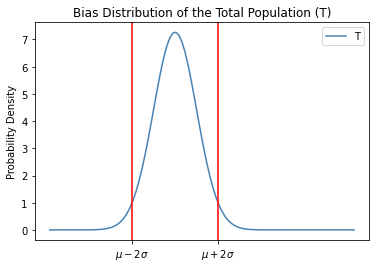

In [48]:
import numpy as np

# Sort the data in ascending order
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

total_pop = [b for _, b in biased_words]
x = np.linspace(np.min(total_pop), np.max(total_pop), 100)

# Calculate the probability density function (PDF) of the total_pop
mu = np.mean(total_pop)
sigma = np.std(total_pop)

pdf = norm.pdf(x, mu, sigma)

# Plot the curve
plt.plot(x, pdf, color='steelblue', label='T')
plt.axvline(x=mu - 2 * sigma, color = "red")
plt.axvline(x=mu + 2 * sigma, color = "red")

plt.title('Bias Distribution of the Total Population (T)')
# plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.xticks([mu - 2 * sigma, mu + 2 * sigma],[r"$\mu - 2\sigma$", r"$\mu + 2\sigma$"])
# Add a legend
plt.legend()

# Display the plot
plt.show()


In [49]:
mu-2*sigma, mu+2*sigma

(-0.1190137237760166, 0.10044230848421809)

In [50]:
import numpy as np


# Sort the data in ascending order
total_pop = [b for _, b in biased_words]
sorted_data = np.sort(total_pop)
# Calculate the quantiles for the three segments
quantiles = np.quantile(sorted_data, [0.1, 0.9])
# Divide the data based on the quantile thresholds
male_pop = sorted_data[sorted_data <= quantiles[0]]
neutral_pop = sorted_data[(sorted_data > quantiles[0]) & (sorted_data < quantiles[1])]
female_pop = sorted_data[sorted_data > quantiles[1]]
male_pop.mean(), female_pop.mean()

(-0.11139433592347867, 0.08476272993192321)

In [51]:
U_1 = []
U_2 = []
U_n = []

for ind in range(len(data)):
    sample = wbias[ind]

    likelihood1 = np.sum((norm.logpdf(sample, np.mean(female_pop), np.std(female_pop))))
    likelihood2 = np.sum((norm.logpdf(sample, np.mean(male_pop), np.std(male_pop))))
    likelihood3 = np.sum((norm.logpdf(sample, np.mean(neutral_pop), np.std(neutral_pop))))

    # Compare likelihoods
    likelihoods = [likelihood1, likelihood2, likelihood3]
    population_labels = ['Population 0', 'Population 1', 'Population 2']
    best_fit_population = np.argmax(likelihoods)

    if abs(max(likelihoods)) < 0:
        U_n.append((ind, max(likelihoods)))
        continue

    if best_fit_population == 2:
        U_n.append((ind, max(likelihoods)))
    elif best_fit_population == 0 and max(likelihoods) :
        U_1.append((ind, max(likelihoods)))
    else:
        U_2.append((ind, max(likelihoods)))

In [52]:
for s in data[data.index.isin([i for i, _ in U_1])].text:
    print(s)

Can’t even send a message in peace pic.twitter.com/HZf5wYaOGn
My neon... I'm happy with the old photo and I'm already making a new Akali suit..
Beautiful @ GhostRecon.
these pies won't stop moving and I'll get 5
Bravo @riotgames always know how to get me hyped for the @LeagueOfLegends ranked season super excited. 
Can I please have sex with you in this game? Can not, I’ll still buy this but I won’t be happy about you.
You are my God
the most satisfying sound you'll here all day. . . . @PlayApex . .  
this is gonna be great.
Turmoil in Turkey by Jon Grainge amazon.com/dp/1366525523/… via @amazon 
I'm back playing OverWatch after a year off.. I'm still pretty damn good.
Microsoft Forecasts a Rise in HyperWorking Across Asia Pacific snip.ly / zbwxkc
I would are grateful.
@roundedtiktak thank you<unk>
Oh yeah happy Fifa 21 day everyone
Great pictures from @ Ramsey111uk.
Hmmmmmmmm, that could be really good
Dr. @ LisaSu clapping hard in the morning @ nvidia and @ intel in the evening, what 

In [54]:
for s in data[data.index.isin([i for i, _ in U_2])].text:
    print(s)

CS Legends of Runeterra - Master. Teamfight Tactics - Master. League of Legends - Gold 2. . I guess I'm just bad at skill-based games.  pic.twitter.com/WNSy8QaGL6
Red Cross Redemption about to go on Xbox Game Pass at.com/all-articles/n... 
by
Wait as this kinda hype
Fortnite needs her nerf smgs they looked so fucking broken
<unk><unk>.. I.be/RtEUnyYvjU0 
Johnson  Johnson Halts Talc Baby Big Show]
GARBAGE
Shit be mad r.
Nvidia Valuation Soars Past Intel on Graphics Chip Boom resetera.com/threads/nvidia… 
Amazon Prime Day is still running, but belatedly.
Lol @Facebook is blocking links to multiple negative news websites about
Unrabked is the by far best all Siege has right up.
STPic.fm / CwGM3OMhMq
nan
Come watch my Buddy Wagner and me for bad play and even worse jokes Rose League Call Duty Warzone Streaming at 2am, maybe later Come hang out:)
Arcstar  . . store.playstation.com/ 
nan
Lollipop.
WELCOME BACK<unk>
 
@EAHelp still cant always be online in Pokémon Battlefield V, from in Turke